In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Advanced deep learning for computer vision

/content/drive/My Drive/Advanced deep learning for computer vision


In [ ]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, img_name) for img_name in os.listdir(input_dir) if img_name.lower().endswith(".jpg") ]
                         )
target_paths = sorted(
    [os.path.join(target_dir, target_name) for target_name in os.listdir(target_dir) if target_name.endswith(".png") and not target_name.lower().startswith(".")]
)

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted(
[os.path.join(input_dir, fname)
for fname in os.listdir(input_dir)
if fname.endswith(".jpg")])
target_paths = sorted(
[os.path.join(target_dir, fname)
for fname in os.listdir(target_dir)
if fname.endswith(".png") and not fname.startswith(".")])

In [3]:
import matplotlib.pyplot as plt
import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Input, Model, models, losses, metrics
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import h5py

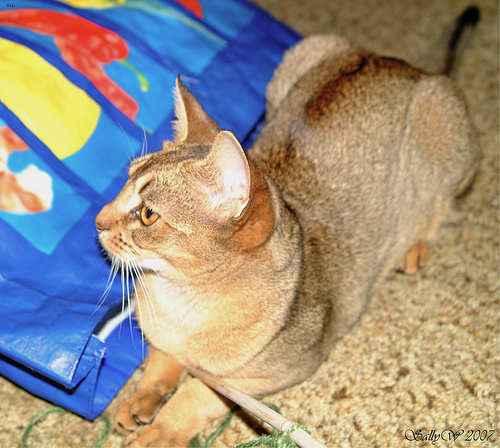

In [ ]:
load_img(input_img_paths[9])

In [ ]:
target_array = img_to_array(load_img(target_paths[9], color_mode='grayscale'))
def display_target(target_array):
  normalized_array = (target_array.astype('uint8') - 1) * 127
  plt.axis('off')
  plt.imshow(normalized_array[:, :, 0])

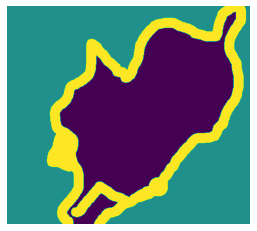

In [ ]:
display_target(target_array)

In [ ]:
import numpy as np 
rpg = np.random.RandomState(seed=1337)
rpg.shuffle(input_img_paths)
rpg = np.random.RandomState(seed=1337)
rpg.shuffle(target_paths)

In [ ]:
import h5py

In [ ]:
# import numpy as np
# import random
# img_size = (200, 200)
# num_imgs = len(input_img_paths)
# # random.Random(1337).shuffle(input_img_paths)
# # random.Random(1337).shuffle(target_paths)
# def path_to_input_image(path):
#   return img_to_array(load_img(path, target_size=img_size))
# def path_to_target(path):
#   img = img_to_array(
#   load_img(path, target_size=img_size, color_mode="grayscale"))
#   img = img.astype("uint8") - 1
#   return img
# input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
# targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
# for i in range(num_imgs):
#   input_imgs[i] = path_to_input_image(input_img_paths[i])
#   targets[i] = path_to_target(target_paths[i])
#   break
# num_val_samples = 1000
# train_input_imgs = input_imgs[:-num_val_samples]
# train_targets = targets[:-num_val_samples]
# val_input_imgs = input_imgs[-num_val_samples:]
# val_targets = targets[-num_val_samples:]

In [ ]:
img_size = (200, 200)
num_imgs = len(input_img_paths)
def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
  img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype('uint8') - 1
  return img
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
file = h5py.File('oxford_dataset.hdf5', 'w') 
file.create_dataset("input_imgs", data=input_imgs)
file.create_dataset("targets", data=targets)
file.close()
for i in range(num_imgs):
  file = h5py.File('oxford_dataset.hdf5', 'a')    
  file['input_imgs'][i] = path_to_input_image(input_img_paths[i])
  file['targets'][i] = path_to_target(target_paths[i])
  file.close()



In [ ]:
file = h5py.File("oxford_dataset.hdf5", 'r')
input_imgs = file['input_imgs']
targets = file['targets']
num_val_samples = 1000
train_input_imgs = input_imgs[num_val_samples:]
train_targets = targets[num_val_samples:]
val_input_imgs = input_imgs[:num_val_samples]
val_targets = targets[:num_val_samples]
file.close()

In [ ]:
def get_model(img_size, num_classes=3):
  inputs = keras.Input(shape=img_size+(3,))
  x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

  x = layers.Conv2DTranspose(filters=256, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=128, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)

  outputs = layers.Conv2D(filters=3, kernel_size=num_classes, activation="softmax", padding="same")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

  

In [ ]:
img_size = train_input_imgs.shape[1 : 3]
num_classes = 3
model = get_model(img_size=img_size)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 256)       2951

In [ ]:
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=metrics.SparseCategoricalAccuracy())

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='oxford_segmentation.keras',
    save_best_only=True,
    monitor='val_loss'
)

history = model.fit(
    x=train_input_imgs,
    y=train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets)
)

Epoch 1/50
100/100 [==============================] - 4431s 44s/step - loss: 3.5877 - sparse_categorical_accuracy: 0.5781 - val_loss: 0.8689 - val_sparse_categorical_accuracy: 0.5861
Epoch 2/50
 91/100 [==========================>...] - ETA: 6:21 - loss: 0.8797 - sparse_categorical_accuracy: 0.5860

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(12, 8))
plt.plot(loss, '-bo', markersize=15, label='Training Loss')
plt.plot(val_loss, '-b', linewidth=15, label='Validation Loss')
plt.title('Training and Validation Loss', fontdict={'fontsize': 20})
plt.gca().tick_params(labelsize=15)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Text(0.5, 1.0, 'Predicted output')

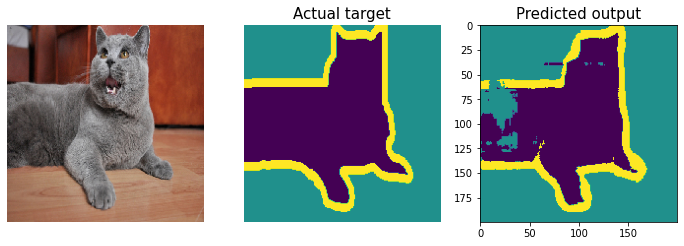

In [ ]:
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
test_target = val_targets[i]
pred_target = (np.argmax(model.predict(np.expand_dims(test_image, axis=0)), axis=-1) * 127)[0] 
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(131)
ax1.imshow(test_image.astype('int'))
ax1.axis('off')
ax2 = fig.add_subplot(132)
ax2.imshow((test_target[:, :, 0])* 127)
ax2.axis('off')
ax2.set_title('Actual target', fontsize=15)
ax3 = fig.add_subplot(133)
ax3.imshow(pred_target)
ax3.set_title('Predicted output', fontsize=15)

## 9.3 Modern convnet architecture patterns

### 9.3.2 Residual connections

In [ ]:
x = tf.Variable(tf.random.normal(shape=(180, 180, 3), mean=0, stddev=1))
residual = x
x = block(x)
x = add([x, residual])

#### Listing 9.2 Case where the target block changes the number of output filters

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(filters=64, kernel_size=1)(residual)
outputs = layers.add([x, residual])
model = Model(inputs=inputs, outputs=outputs)

#### Listing 9.3 Case where the target block includes a max pooling layer

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
residual = layers.Conv2D(filters=64, strides=2, kernel_size=1)(residual)
outputs = tf.keras.layers.add([x, residual])
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 30, 30, 32)   896         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 30, 30, 64)   18496       conv2d_34[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 15, 15, 64)   0           conv2d_35[0][0]                  
____________________________________________________________________________________________

In [ ]:
input = tf.keras.Input(shape=(32, 32, 3))
x = layers.experimental.preprocessing.Rescaling(1/255.)(inputs)
def residual_block(x, filters, pooling=False):
  residual = x
  x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(x)
  if pooling:
    x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
    residual = layers.Conv2D(filters=filters, kernel_size=1, strides=2)(residual)
  elif filters != residual.shape[-1]:
    residual = layers.Conv2D(filters=filters, kernel_size=1)(residual)
  x = layers.add([x, residual])
  return x
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 32, 32, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 32, 32, 32)   896         rescaling_9[0][0]                
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 32, 32, 32)   9248        conv2d_103[0][0]                 
____________________________________________________________________________________________

### 9.3.3 Batch normalization

In [ ]:
x = ...
x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Activation(activation='relu')(x)

TypeError: ignored

### 9.3.5 Putting it together: a mini Xception-like model

In [ ]:
data_augmentation = models.Sequential([
                                      keras.Input(shape=(180, 180, 3)),
                                      layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1 / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for filters in [32, 64, 128, 256, 512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation(activation='relu')(x)
  x = layers.SeparableConv2D(filters=filters, kernel_size=3, padding='same', use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation(activation='relu')(x)
  x = layers.SeparableConv2D(filters=filters, kernel_size=3, padding='same', use_bias=False)(x)

  x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  residual = layers.Conv2D(filters=filters, kernel_size=1, strides=2, padding='same', use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/My Drive/8. Introduction to deep learning for computer vision/cats_vs_dogs_small/train',
    image_size=(180, 180),
    batch_size=32
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/My Drive/8. Introduction to deep learning for computer vision/cats_vs_dogs_small/validation',
    image_size=(180, 180),
    batch_size=32
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/My Drive/8. Introduction to deep learning for computer vision/cats_vs_dogs_small/test',
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
callbacks = keras.callbacks.ModelCheckpoint(
    filepath='best_dog_cat.hdf5',
    save_best_only=True,
    monitor='val_loss'
)
model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.BinaryCrossentropy(),
    metrics=metrics.BinaryAccuracy()
)
history = model.fit(
    x=train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 75s 484ms/step - loss: 0.6941 - binary_accuracy: 0.5470 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
INFO:tensorflow:Assets written to: best_dog_cat.hfg5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
63/63 [==============================] - 31s 476ms/step - loss: 0.6398 - binary_accuracy: 0.6535 - val_loss: 0.6936 - val_binary_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 31s 480ms/step - loss: 0.5911 - binary_accuracy: 0.6890 - val_loss: 0.6985 - val_binary_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 31s 477ms/step - loss: 0.5593 - binary_accuracy: 0.7290 - val_loss: 0.7061 - val_binary_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 31s 476ms/step - loss: 0.5357 - binary_accuracy: 0.7460 - val_loss: 0.7272 - val_binary_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 31s 478ms/step - loss: 0.5099 - binary_accuracy: 0.7545 - val_loss: 0.7912 - val_binary_accuracy: 0.5010
Epoch 7/100
63/63 [==============================] - 31s 481ms/step - loss: 0.4830 - binary_accuracy: 0.7705 - val_loss: 0.8919 - val_binary_accuracy: 0.5530
Epoch 8/100
63/63 [==============================] -

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
63/63 [==============================] - 31s 481ms/step - loss: 0.4675 - binary_accuracy: 0.7885 - val_loss: 0.5152 - val_binary_accuracy: 0.7290
INFO:tensorflow:Assets written to: best_dog_cat.hfg5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
63/63 [==============================] - 31s 484ms/step - loss: 0.4432 - binary_accuracy: 0.7940 - val_loss: 0.4942 - val_binary_accuracy: 0.7740
INFO:tensorflow:Assets written to: best_dog_cat.hfg5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
63/63 [==============================] - 31s 476ms/step - loss: 0.4152 - binary_accuracy: 0.8100 - val_loss: 0.8905 - val_binary_accuracy: 0.5780
Epoch 13/100
63/63 [==============================] - 31s 479ms/step - loss: 0.4234 - binary_accuracy: 0.8080 - val_loss: 0.5707 - val_binary_accuracy: 0.7570
Epoch 14/100
63/63 [==============================] - 31s 483ms/step - loss: 0.4144 - binary_accuracy: 0.8120 - val_loss: 1.9611 - val_binary_accuracy: 0.6430
Epoch 15/100
63/63 [==============================] - 31s 480ms/step - loss: 0.4072 - binary_accuracy: 0.8150 - val_loss: 0.4471 - val_binary_accuracy: 0.7980
INFO:tensorflow:Assets written to: best_dog_cat.hfg5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/100
63/63 [==============================] - 31s 478ms/step - loss: 0.3911 - binary_accuracy: 0.8260 - val_loss: 0.5429 - val_binary_accuracy: 0.7790
Epoch 17/100
63/63 [==============================] - 31s 476ms/step - loss: 0.3805 - binary_accuracy: 0.8410 - val_loss: 1.6458 - val_binary_accuracy: 0.6280
Epoch 18/100
63/63 [==============================] - 31s 475ms/step - loss: 0.3722 - binary_accuracy: 0.8295 - val_loss: 0.6446 - val_binary_accuracy: 0.7620
Epoch 19/100
63/63 [==============================] - 31s 482ms/step - loss: 0.3548 - binary_accuracy: 0.8500 - val_loss: 0.5772 - val_binary_accuracy: 0.7810
Epoch 20/100
63/63 [==============================] - 31s 480ms/step - loss: 0.3737 - binary_accuracy: 0.8360 - val_loss: 0.7473 - val_binary_accuracy: 0.6950
Epoch 21/100
63/63 [==============================] - 31s 478ms/step - loss: 0.3493 - binary_accuracy: 0.8520 - val_loss: 1.5281 - val_binary_accuracy: 0.6460
Epoch 22/100
63/63 [==========================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/100
63/63 [==============================] - 31s 478ms/step - loss: 0.2271 - binary_accuracy: 0.9045 - val_loss: 0.4808 - val_binary_accuracy: 0.8500
Epoch 42/100
63/63 [==============================] - 31s 483ms/step - loss: 0.2263 - binary_accuracy: 0.9085 - val_loss: 0.7762 - val_binary_accuracy: 0.7540
Epoch 43/100
63/63 [==============================] - 31s 479ms/step - loss: 0.2227 - binary_accuracy: 0.9140 - val_loss: 0.6054 - val_binary_accuracy: 0.8180
Epoch 44/100
63/63 [==============================] - 31s 483ms/step - loss: 0.2117 - binary_accuracy: 0.9110 - val_loss: 0.7912 - val_binary_accuracy: 0.7830
Epoch 45/100
63/63 [==============================] - 31s 482ms/step - loss: 0.2175 - binary_accuracy: 0.9195 - val_loss: 0.4722 - val_binary_accuracy: 0.8100
Epoch 46/100
63/63 [==============================] - 31s 477ms/step - loss: 0.2085 - binary_accuracy: 0.9155 - val_loss: 0.5537 - val_binary_accuracy: 0.7680
Epoch 47/100
63/63 [==========================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 64/100
63/63 [==============================] - 31s 478ms/step - loss: 0.1722 - binary_accuracy: 0.9355 - val_loss: 1.0320 - val_binary_accuracy: 0.7650
Epoch 65/100
63/63 [==============================] - 31s 476ms/step - loss: 0.1596 - binary_accuracy: 0.9395 - val_loss: 0.3692 - val_binary_accuracy: 0.8460
INFO:tensorflow:Assets written to: best_dog_cat.hfg5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 66/100
63/63 [==============================] - 31s 479ms/step - loss: 0.1565 - binary_accuracy: 0.9370 - val_loss: 0.4221 - val_binary_accuracy: 0.8550
Epoch 67/100
63/63 [==============================] - 30s 473ms/step - loss: 0.1314 - binary_accuracy: 0.9445 - val_loss: 0.7997 - val_binary_accuracy: 0.8300
Epoch 68/100
63/63 [==============================] - 31s 479ms/step - loss: 0.1287 - binary_accuracy: 0.9470 - val_loss: 0.4490 - val_binary_accuracy: 0.8400
Epoch 69/100
63/63 [==============================] - 31s 476ms/step - loss: 0.1517 - binary_accuracy: 0.9395 - val_loss: 1.2495 - val_binary_accuracy: 0.7750
Epoch 70/100
63/63 [==============================] - 31s 477ms/step - loss: 0.1284 - binary_accuracy: 0.9520 - val_loss: 1.4287 - val_binary_accuracy: 0.7800
Epoch 71/100
63/63 [==============================] - 31s 476ms/step - loss: 0.1281 - binary_accuracy: 0.9470 - val_loss: 0.8028 - val_binary_accuracy: 0.8320
Epoch 72/100
63/63 [==========================

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 90/100
63/63 [==============================] - 31s 482ms/step - loss: 0.1007 - binary_accuracy: 0.9620 - val_loss: 0.5026 - val_binary_accuracy: 0.8700
Epoch 91/100
63/63 [==============================] - 31s 473ms/step - loss: 0.1108 - binary_accuracy: 0.9600 - val_loss: 0.3482 - val_binary_accuracy: 0.8770
Epoch 92/100
63/63 [==============================] - 30s 472ms/step - loss: 0.1070 - binary_accuracy: 0.9590 - val_loss: 0.3840 - val_binary_accuracy: 0.8550
Epoch 93/100
63/63 [==============================] - 31s 480ms/step - loss: 0.0842 - binary_accuracy: 0.9695 - val_loss: 0.5884 - val_binary_accuracy: 0.8720
Epoch 94/100
63/63 [==============================] - 31s 475ms/step - loss: 0.0920 - binary_accuracy: 0.9695 - val_loss: 0.6453 - val_binary_accuracy: 0.8800
Epoch 95/100
63/63 [==============================] - 31s 481ms/step - loss: 0.1078 - binary_accuracy: 0.9545 - val_loss: 0.5481 - val_binary_accuracy: 0.8480
Epoch 96/100
63/63 [==========================

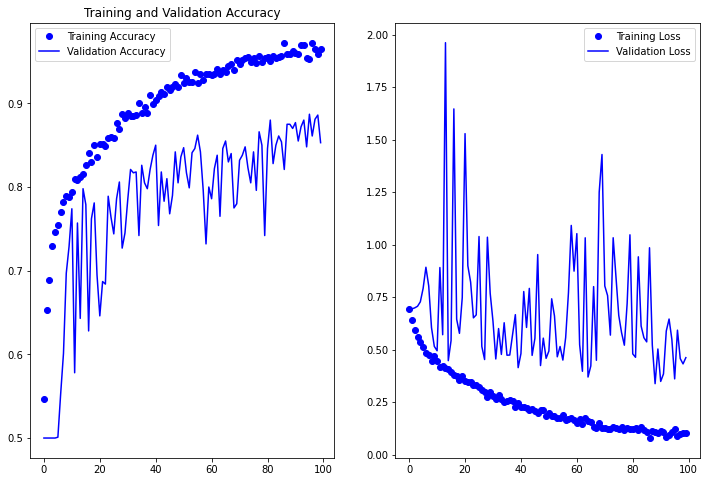

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax1.plot(accuracy, 'bo', label='Training Accuracy')
ax1.plot(val_accuracy, 'b-', label='Validation Accuracy')
ax1.set(title='Training and Validation Accuracy')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(loss, 'bo', label='Training Loss')
ax2.plot(val_loss, 'b-', label='Validation Loss')
ax2.legend()

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1/255.)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=metrics.BinaryAccuracy()
)
callbacks = keras.callbacks.ModelCheckpoint(filepath="cat_dogs_scratch_augmentation.keras", monitor='val_binary_accuracy', save_best_only=True)
history = model.fit(
    x=train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 13s 163ms/step - loss: 0.6940 - binary_accuracy: 0.5015 - val_loss: 0.6929 - val_binary_accuracy: 0.5120
Epoch 2/100
63/63 [==============================] - 10s 147ms/step - loss: 0.6929 - binary_accuracy: 0.5075 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 10s 147ms/step - loss: 0.6899 - binary_accuracy: 0.5205 - val_loss: 0.7450 - val_binary_accuracy: 0.5160
Epoch 4/100
63/63 [==============================] - 10s 147ms/step - loss: 0.6879 - binary_accuracy: 0.5605 - val_loss: 0.6707 - val_binary_accuracy: 0.6200
Epoch 5/100
63/63 [==============================] - 10s 148ms/step - loss: 0.6643 - binary_accuracy: 0.6020 - val_loss: 0.7028 - val_binary_accuracy: 0.5690
Epoch 6/100
63/63 [==============================] - 10s 146ms/step - loss: 0.6467 - binary_accuracy: 0.6290 - val_loss: 0.6537 - val_binary_accuracy: 0.6100
Epoch 7/100
63/63 [==============================] -

In [ ]:
model = tf.keras.models.load_model('cat_dogs_scratch_augmentation.keras')

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 43, 43, 64)        0   

In [ ]:
img_path = keras.utils.get_file(fname='cat.jpg', origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

90112/80329 [=================================] - 0s 0us/step


In [ ]:
from keras.preprocessing.image import load_img, img_to_array


### Listing 9.6 Preprocessing a single image

In [4]:
target_size = (180, 180)

img_path = keras.utils.get_file(fname='cat.jpg', origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
def get_img(img_path, target_sie):
  array = img_to_array(keras.preprocessing.image.img_to_array(load_img(img_path, target_size=target_size)))
  array = np.expand_dims(array, axis=0)
  return array

90112/80329 [=================================] - 0s 2us/step


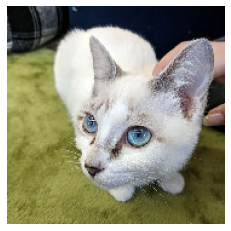

In [5]:
img_array = get_img(img_path, target_size)
plt.imshow(img_array.astype('uint8')[0])
plt.axis('off')
plt.show()

In [ ]:
model.evaluate(test_data)

NameError: ignored

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)
activation_model = Model(inputs=model.input, outputs=layer_outputs)    

In [ ]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 43, 43, 64)        0     

In [ ]:
activations = activation_model.predict(img_array)
activation0 = activations[0]

(1, 178, 178, 32)


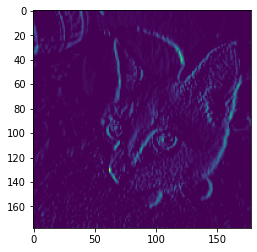

In [ ]:
print(activation0.shape)
plt.imshow(activation0[0, :, :, 5], cmap='viridis')

### Listing 9.11 Visualizing every channel in every intermediate activation

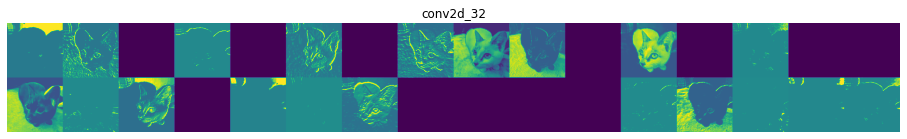

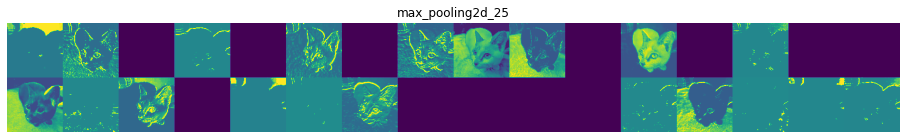

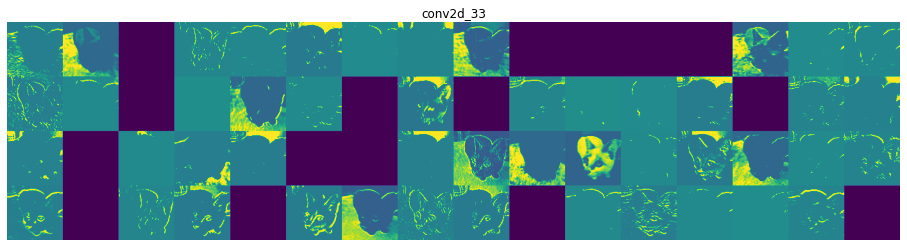

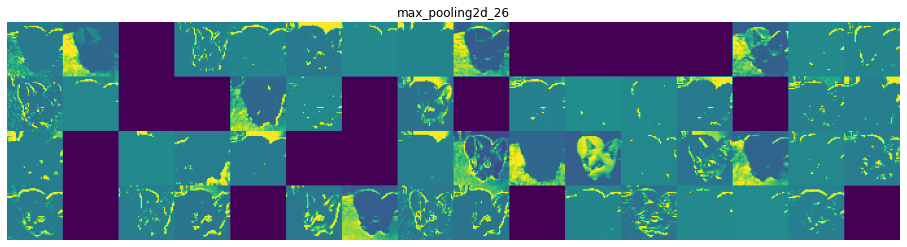

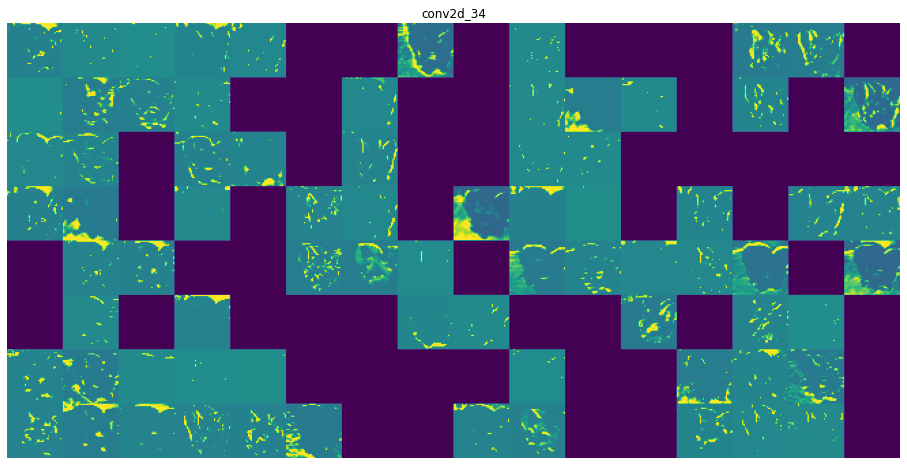

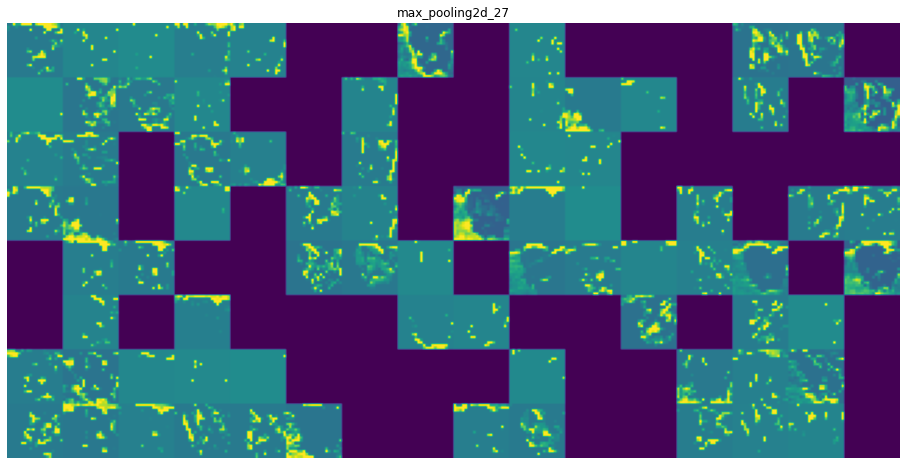

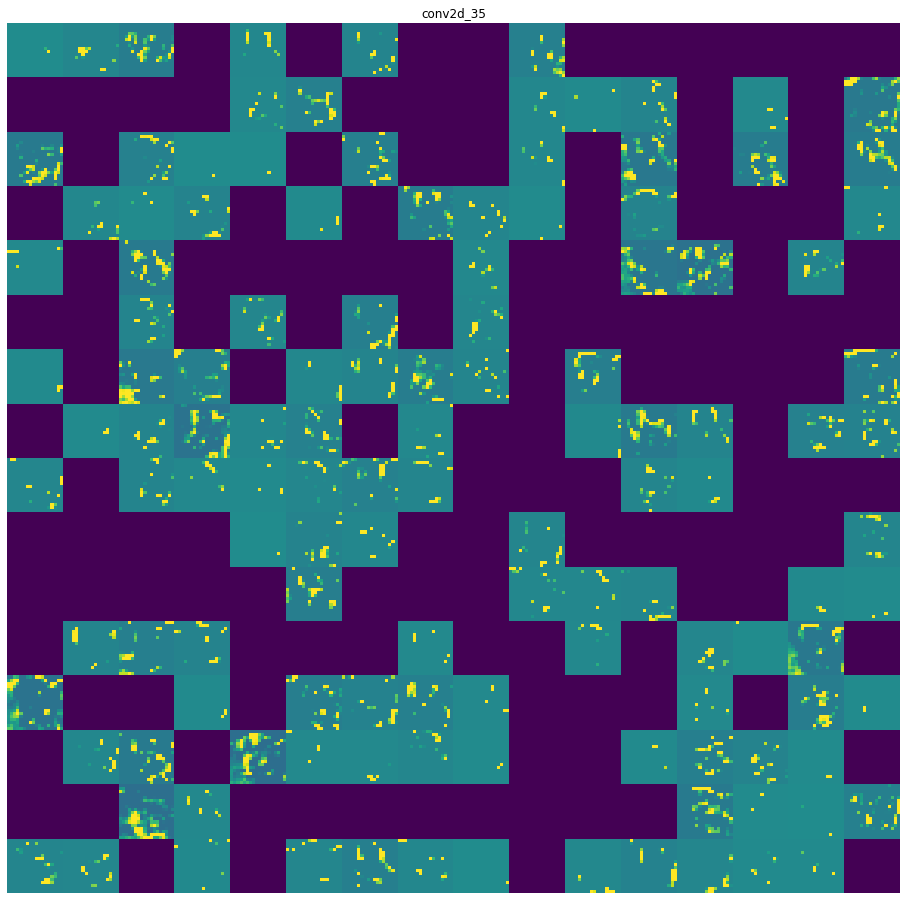

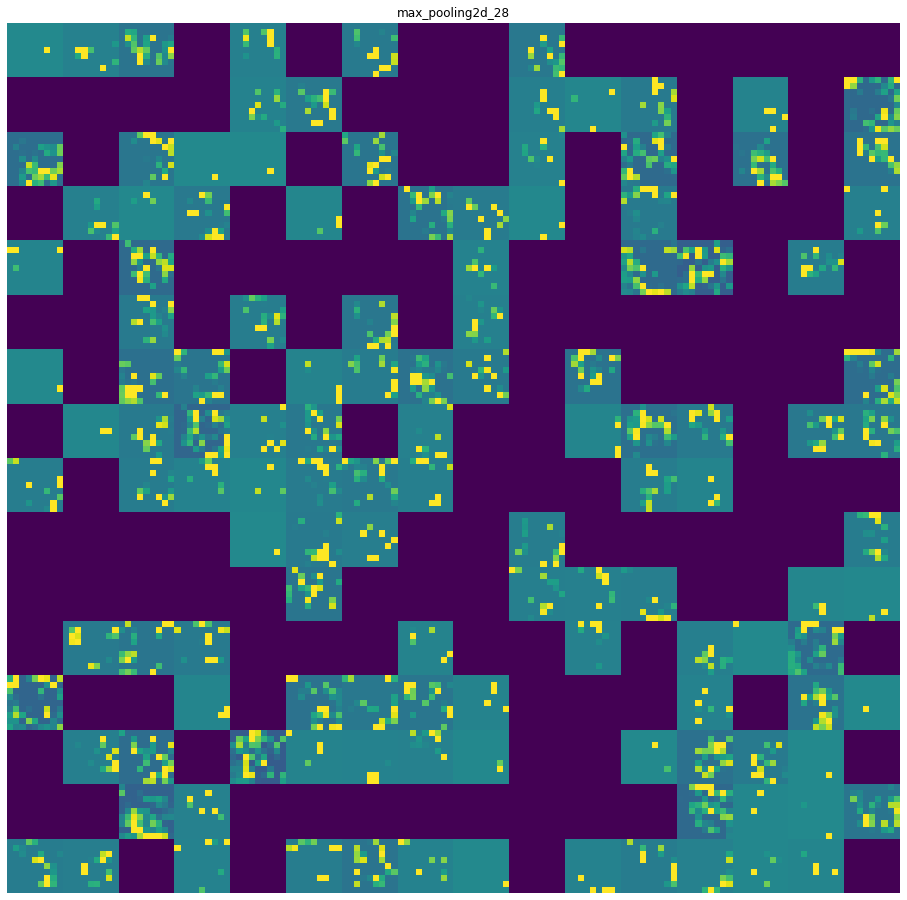

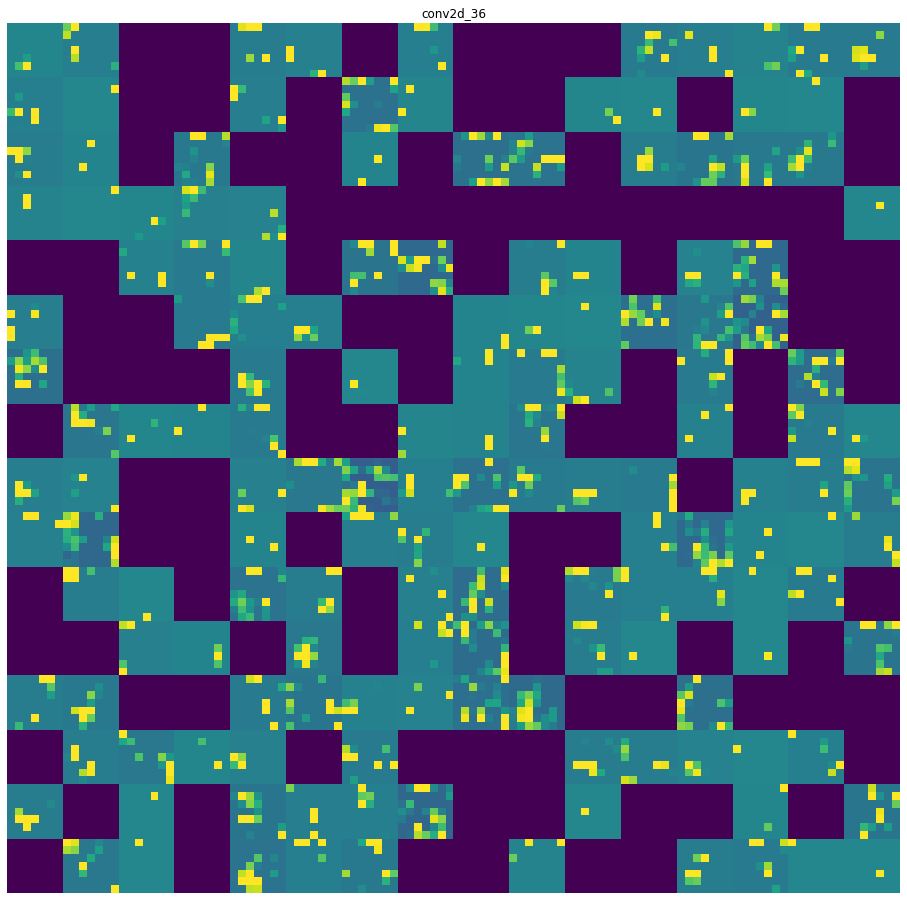

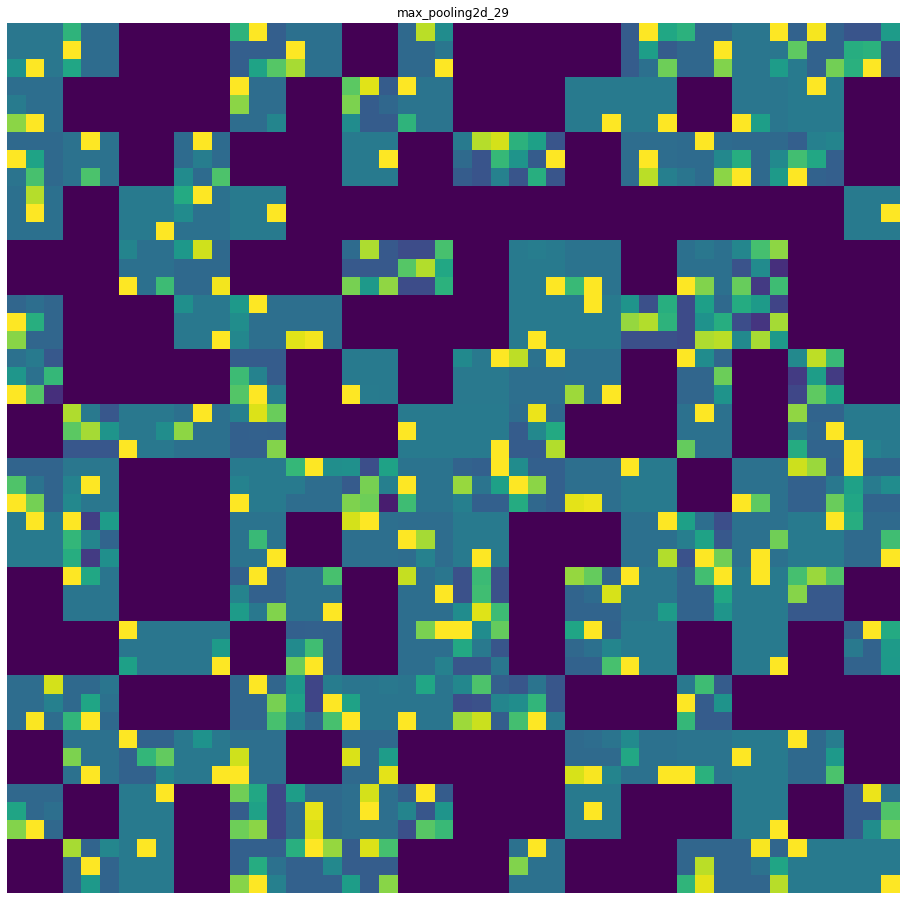

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = np.ceil(n_features / images_per_row).astype('int')
  display_grid = np.zeros((size * n_cols, size * images_per_row))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, (col * images_per_row) + row].copy()
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
      
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')

      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.axis('off')
  plt.imshow(display_grid, aspect='auto')
  plt.title(layer_name)

### 9.4.2 Visualizing convnet filters

#### Listing 9.12 Instantiating the Xception convolutional base

In [6]:
model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

83697664/83683744 [==============================] - 1s 0us/step


In [7]:
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [8]:
layer_name = 'block3_sepconv1'
outputs = model.get_layer(name=layer_name).output
feature_extractor = Model(inputs=model.input, outputs=outputs)

In [9]:
activations = feature_extractor(tf.keras.applications.xception.preprocess_input(img_array))

In [10]:
def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

In [25]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image, filter_index)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  print(tf.shape(grads))
  return image

#### Listing 9.17 Function to generate filter visualizations

In [32]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
  iterations = 30
  learning_rate = 10
  image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3))
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate=learning_rate)
  return image[0].numpy()

#### Listing 9.18 Utility function to convert a tensor into a valid image

In [40]:
def decompress_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image *= 128
  image = np.clip(image, 0, 255)
  image = image[25:-25, 25:-25, :]
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


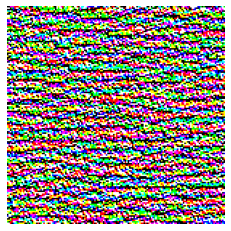

In [47]:
plt.axis('off')
plt.imshow(decompress_image(generate_filter_pattern(filter_index=2
                                                   )))

In [42]:
decompress_image(generate_filter_pattern(filter_index=2
                                                   )).shape

(150, 150, 3)